In [1]:
!nvidia-smi

Mon Oct  4 05:32:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
 !mkdir -p ~/.kaggle
 !mv kaggle.json ~/.kaggle/
 !ls ~/.kaggle
 !chmod 600 /root/.kaggle/kaggle.json
 !kaggle datasets download -d sixhky/open-images-bus-trucks/
 !unzip -qq open-images-bus-trucks.zip
 !rm open-images-bus-trucks.zip

kaggle.json
 99% 362M/367M [00:02<00:00, 147MB/s]
100% 367M/367M [00:02<00:00, 133MB/s]


In [3]:
!pip install torch-snippets
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

     |████████████████████████████████| 41 kB 284 kB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 211 kB 32.7 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 10.1 MB 17.1 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
/content/ssd-utils


In [4]:
from PIL import Image
from torch_snippets import *
import numpy as np
import pandas as pd
import cv2
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from numpy import moveaxis
from numpy import asarray
import torchvision
from model import SSD300, MultiBoxLoss
from detect import *

In [5]:
DF_RAW=pd.read_csv('/content/df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
img_folder='/content/images/images/'

In [8]:
from torchvision import transforms

In [9]:
class OpenDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.df=df
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  def __len__(self):
    return len(self.df)
  def __getitem__(self, ix):
    img_id=self.df.iloc[ix, 0]
    img_id=img_id+'.jpg'
    img_path=os.path.join(img_folder, img_id)
    img = Image.open(img_path).convert("RGB")
    img = np.array(img.resize((300, 300), resample=Image.BILINEAR))/255
    box_pts=self.df.iloc[ix, 4:8].values
    temp=box_pts[2]
    box_pts[2]=box_pts[1]
    box_pts[1]=temp
    img_class=self.df.iloc[ix, 2]
    if (img_class=='Bus'):
      img_class=[1]
    elif (img_class=='Truck'):
      img_class=[2]
    else:
      img_class=[0]
    box_pts=[(box_pts* np.array([300, 300, 300, 300])).astype(np.uint32).tolist()]
    return img, box_pts, img_class
  def collate_fn(self, batch):
    images, boxes, labels=[], [], []
    for item in batch:
      img, img_boxes, img_labels=item
      img = torch.tensor(img).permute(2,0,1)
      img = self.normalize(img)
      img = img.float().to(device)
      images.append(img[None])
      boxes.append(torch.tensor(img_boxes).float().to(device)/300)
      labels.append(torch.tensor(img_labels).long().to(device))
    images=torch.cat(images).to(device)
    return images, boxes, labels

In [10]:
from torch.utils.data import DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


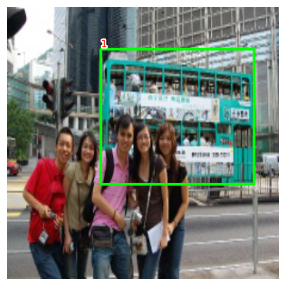

[[103, 46, 272, 195]] [1]


In [11]:
od=OpenDataset(DF_RAW)
img_final, box_pts, img_class=od[0]
show(img_final, bbs=box_pts, texts=img_class, sz=5)
print(box_pts, img_class)

In [12]:
train_ds=OpenDataset(DF_RAW)
train_loader=DataLoader(train_ds, batch_size=16, collate_fn=train_ds.collate_fn ,drop_last=True)

In [13]:
for ix, inputs in enumerate(train_loader):
  images, boxes, labels = inputs
  print(images.shape)
  print(boxes)
  print(labels)
  break

torch.Size([16, 3, 300, 300])
[tensor([[0.3433, 0.1533, 0.9067, 0.6500]], device='cuda:0'), tensor([[0.2767, 0.1400, 0.6967, 0.4367]], device='cuda:0'), tensor([[0.7000, 0.2033, 0.9967, 0.4067]], device='cuda:0'), tensor([[0.1533, 0.2667, 0.3700, 0.7033]], device='cuda:0'), tensor([[0.2867, 0.1933, 0.9967, 0.9967]], device='cuda:0'), tensor([[0.0600, 0.1233, 0.9667, 0.9733]], device='cuda:0'), tensor([[0.0567, 0.0500, 0.9800, 0.9400]], device='cuda:0'), tensor([[0.0333, 0.1867, 0.1867, 0.3200]], device='cuda:0'), tensor([[0.0933, 0.1467, 0.8967, 0.9333]], device='cuda:0'), tensor([[0.8600, 0.2467, 0.9967, 0.3900]], device='cuda:0'), tensor([[0.0000, 0.1867, 0.7000, 0.9967]], device='cuda:0'), tensor([[0.0000, 0.0667, 0.5867, 0.9967]], device='cuda:0'), tensor([[0.1600, 0.2667, 0.9267, 0.9300]], device='cuda:0'), tensor([[0.0000, 0.0000, 0.9967, 0.9967]], device='cuda:0'), tensor([[0.1567, 0.2500, 0.7200, 0.7300]], device='cuda:0'), tensor([[0.6200, 0.4067, 0.9967, 0.6467]], device='cud

In [14]:
model = SSD300(3, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [15]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [16]:
Loss=[]

In [17]:
for epoch in range(0, 2):
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    batch_loss.append(loss.item())
  print(epoch)
  Loss.append(np.mean(batch_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0
1


In [18]:
for epoch in range(2, 4):
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    batch_loss.append(loss.item())
  print(epoch)
  Loss.append(np.mean(batch_loss))

2
3


In [19]:
for epoch in range(4, 5):
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    loss = train_batch(inputs, model, criterion, optimizer)
    batch_loss.append(loss.item())
  print(epoch)
  Loss.append(np.mean(batch_loss))

4


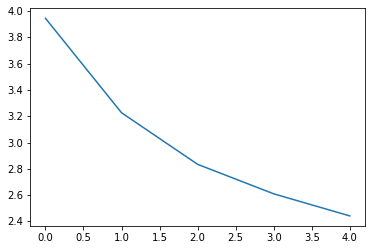

In [20]:
plt.plot(Loss)

[[77, 39, 175, 133]] tensor([1], device='cuda:0') [0.9448816180229187]


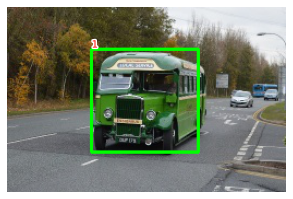

In [21]:
img_path='/content/images/images/004e03d45963728e.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

[[23, 41, 157, 139]] tensor([2], device='cuda:0') [0.8624223470687866]


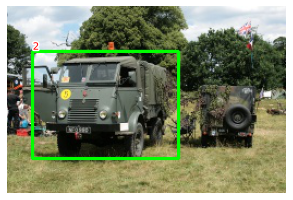

In [22]:
img_path=r'/content/images/images/000817a6f6819e73.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

[[18, 30, 244, 168]] tensor([2], device='cuda:0') [0.5842199325561523]


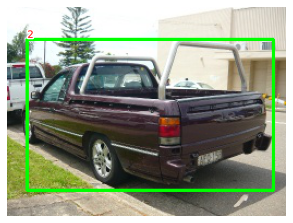

In [23]:
img_path='/content/images/images/0022fdfc1880d432.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.5, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

[[82, 72, 232, 179]] tensor([2], device='cuda:0') [0.9699515104293823]


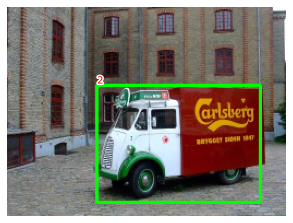

In [24]:
img_path='/content/images/images/003551f1525e49af.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

[[31, 7, 205, 118]] tensor([1], device='cuda:0') [0.8021105527877808]


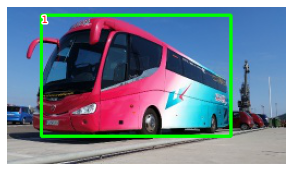

In [25]:
img_path='/content/images/images/004f297994c65d21.jpg'
original_image = Image.open(img_path, mode='r')
bbs, labels, scores = detect(original_image, model, min_score=0.8, max_overlap=0.5,top_k=200, device=device)
print(bbs, labels, scores)
show(original_image, bbs=bbs, texts=labels, text_sz=10)

In [28]:
torch.save(model.to('cpu').state_dict(), '/content/SSD.pth')